# Домашняя работа 8. Деревья решений. (32 балла)

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #8: Name Surname`. Если тема будет неправильная, то задание не будет проверено.
6. Дедлайн: 18.12.2017 01:00 OMSK
7. После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

Рассылка решений: 25.12.2017 17:00 OMSK
После рассылки задания почти совсем не имеют веса.

## Полезная литература

- [Habrahabr: ODS деревья решений](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy)
- [ВМК МГУ семинары по решающим деревьям](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem04_trees.pdf)
- [Sklearn Decision Trees](http://scikit-learn.org/stable/modules/tree.html)

## 1. Сравнение моделей деревьев

В этом блоке вы сравните разные конфигурации композиции деревьев:
- DecisionTree
- Bagging
- Bagging с другими настройками подбора признаков для разбиения
- RandomForest

Будем использовать [датасет с винишком](https://archive.ics.uci.edu/ml/datasets/wine+quality) - это задача то ли классификации то ли регресси - нужно предсказывать качество вина. Будем думать что это классификация.

![](https://upload.wikimedia.org/wikipedia/en/thumb/7/7c/Lulz_Security.svg/300px-Lulz_Security.svg.png)

### 1.1 Чтение данных (1 балла)

Данные лежат как обычно в `'../../data/winequality-red.csv.gz'`.

- Прочитайте их с помощью pandas
- нарисуйте countplot целевого признака `quality`.
- Что вы думаете по поводу количества представителей каждого класса.
- Разбейте данные на X и y.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv('data/winequality-red.csv.gz', sep=';')
X, y = data.drop('quality', axis=1), data.quality

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


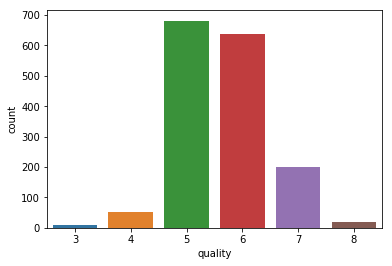

In [3]:
sns.countplot(data.quality, data=data)

Гляда по countplot, можно понять, что выборка несбалансирована.

In [4]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [5]:
y.head()

0    5
1    5
2    5
3    6
4    5
Name: quality, dtype: int64

### 1.2 Сравнение моделей (4 балла)

Задача классификации. Все признаки уже числовые. Значит можно пробовать просто все модели и выбрать лучшую. Так и поступим, сделайте кросс валидацию на 5 фолдах, используя `sklearn.model_selection.KFold` как аргумент у `cross_val_score`. Метрика качества будет `accuracy`.

Алгоритмы для тестирования:
- KNeighborsClassifier с 10 соседями
- KNeighborsClassifier с 10 соседями и масштабированием StandartScaler
- RidgeClassifier
- DecisionTreeClassifier 
- BaggingClassifier c 100 деревьев
- BaggingClassifier с 100 деревьев и каждое дерево обучается только по половине случайно выбранных признаков (см аргументы)
- RandomForestClassifier c 100 деревьев

Выведите среднее значение метрики качества для каждого из классификаторов. 

**hint**: каждый следующий алгоритм, будет показывать качество лучше, чем предыдущий. Если у вас не так - то что-то вы делаете неправильно. Везде зафиксируйте random_state=42.

In [6]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

np.random.seed(seed=42)

##### Обучение KNeighborsClassifier с 10 соседями

In [7]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

kNN = KNeighborsClassifier(n_neighbors=10, n_jobs=4)
%time kNN.fit(X, y)

cross_val_score(kNN, X, y, scoring='accuracy', cv=kf, n_jobs=4).mean()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.98 ms


0.51221982758620688

##### Обучение KNeighborsClassifier с 10 соседями и масштабированием StandartScaler 

In [8]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X, y)

kNN_scaled = KNeighborsClassifier(n_neighbors=10, n_jobs=4)
%time kNN_scaled.fit(X_scaled, y)

cross_val_score(kNN_scaled, X_scaled, y, scoring='accuracy', cv=kf, n_jobs=4).mean()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.16 ms


0.57975313479623825

##### Обучение RidgeClassifier

In [9]:
ridge_clf = RidgeClassifier(random_state=42)
%time ridge_clf.fit(X, y)

cross_val_score(ridge_clf, X, y, scoring='accuracy', cv=kf, n_jobs=4).mean()

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.23 ms


0.58353840125391854

##### Обучение DecisionTreeClassifier

In [10]:
dt_clf = DecisionTreeClassifier(random_state=42)
%time dt_clf.fit(X, y)

cross_val_score(dt_clf, X, y, scoring='accuracy', cv=kf, n_jobs=4).mean()

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 28.2 ms


0.61852076802507827

##### Обучение BaggingClassifier c 100 деревьев

In [11]:
bag_clf = BaggingClassifier(n_estimators=100, n_jobs=4, random_state=42)
%time bag_clf.fit(X, y)

cross_val_score(bag_clf, X, y, scoring='accuracy', cv=kf, n_jobs=1).mean()

CPU times: user 164 ms, sys: 52 ms, total: 216 ms
Wall time: 876 ms


0.69546042319749213

##### Обучение BaggingClassifier c 100 деревьев,  каждое дерево обучается только по половине случайно выбранных признаков

In [12]:
bag_clf = BaggingClassifier(n_estimators=100, max_features=.5, n_jobs=4, random_state=42)
%time bag_clf.fit(X, y)

cross_val_score(bag_clf, X, y, scoring='accuracy', cv=kf, n_jobs=1).mean()

CPU times: user 180 ms, sys: 48 ms, total: 228 ms
Wall time: 787 ms


0.69921630094043885

##### Обучение RandomForestClassifier с 100 деревьев

In [13]:
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=4, random_state=42)
%time rf_clf.fit(X, y)

cross_val_score(rf_clf, X, y, scoring='accuracy', cv=kf, n_jobs=1).mean()

CPU times: user 964 ms, sys: 40 ms, total: 1 s
Wall time: 603 ms


0.70109130094043892

### 1.3 Расуждения (8 баллов)

Ответьте на вопросы развернуто, можете полистать литературу:

- почему наблюдается значимая разница в качестве у KNeighborsClassifier с масштабированием и без
- почему масштабирование не важно для деревьев решений
- почему бэггинг на половине признаков для каждого дерева дал качество предсказания больше, чем на всех? (а он дал!)
- у какой модели наибольшей отклонение от среднего качества предсказаний? А почему??

1. Числовые признаки разного масштаба дают разный по величине вклад во время обучения. Подсчет расстояния между объектами очень зависит от значений координат этих объектов. StandardScaler нормирует признаки таким образом, что среднее и отклонение становятся равны единице. Таким образом нормируются и покоординатные разности для каждой пары объекта, что важно, т.к. метрика Минковского учитыват как раз эти разности.

2. Критерий выбора условия деления выборки строится таким образом, что.

3. 

4. 

## 2 Переобучение и Ко

В последнем задании вы уже заметили, что случайный лес может вести себя немного нестабильно. В этом задании мы возьмем опять датасет MNIST(простите) и будем его решать деревьями. Почему мы взяли его? Потому что в нем фактически много разных признаков (значения пикселей в пространстве), а деревья строятсья делая разбиения по признакам. Обычно на эти разбиения не обращают внимание, так как главное что тюнят - это глубина дереьвев, количество деревьев, а кучу других параметров обходят стороной, так как они "неясные". Попробуем прояснить их.

### 2.1 Загрузка датасета (1 балл)

Загрузите датасет с помощью функции `sklearn.datasets.load_digits`. В нем будут 64px картинки в векторной форме.

Нарисуйте первые 10 цифр в одной ячейке, чтобы было красиво.

In [14]:
from sklearn.datasets import load_digits
dig_X, dig_y = load_digits(return_X_y=True)

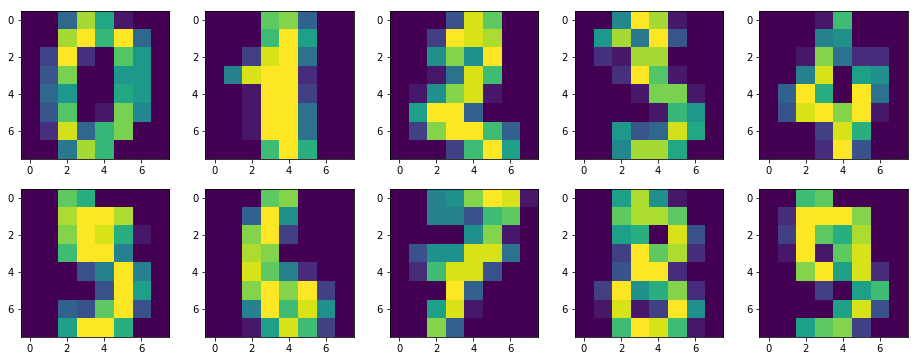

In [15]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(dig_X[i,:].reshape([8,8]))

### 2.2 Перебор классификаторов (3 балла)

В этом задании вам снова придется перебрать несколько классификаторов, но теперь мы обратим внимание на другие гиперпараметры и их влияние на качество классификации, кстати опять `accuracy`.

Сделайте кроссвалидацию на 10 фолдах, указав `cv=10` для следующих классификаторов:

- DecisionTreeClassifier с параметрами по-умолчанию
- BaggingClassifier с 100 деревьвев
- BaggingClassifier с 100 деревьев, НО с ограничением на максимальное количество признаков, участвующих при обучении каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков.
- BaggingClassifier с 100 деревьев, НО с ограничением на количество признаков участвующих в разбиении для каждого из деревьев в $\sqrt{N}$, где $N$ - это число признаков. Это отличается от предыдущей модели тем, где ограничивается `max_features`. Читайте документацию :trollface:
- обычный случайный лес со 100 деревьями

In [16]:
clfs = [
    ('Decision tree (default parameters)', DecisionTreeClassifier(random_state=42)),
    ('Bagging clf (100 estimators)', BaggingClassifier(n_estimators=100, n_jobs=4, random_state=42)),
    ('Bagging clf (100 estimators, max_features=sqrt(N))', 
         BaggingClassifier(n_estimators=100, max_features=int(np.sqrt(len(dig_X[0]))), n_jobs=4, random_state=42)),
    ('Bagging clf (100 estimators, max_samples=sqrt(N))', 
         BaggingClassifier(base_estimator=DecisionTreeClassifier(
             random_state=42, max_features=int(np.sqrt(len(dig_X[0])))
         ), n_estimators=100, n_jobs=4, random_state=42)),
    ('Random forest (100 estimators)', RandomForestClassifier(n_estimators=100, random_state=42))
]

In [17]:
for c in clfs:
    print(c[0], ':')
    %time c[1].fit(dig_X, dig_y)
    print('Score:', cross_val_score(c[1], dig_X, dig_y, scoring='accuracy', cv=10, n_jobs=1).mean(), '\n')

Decision tree (default parameters) :
CPU times: user 40 ms, sys: 4 ms, total: 44 ms
Wall time: 41.9 ms
Score: 0.837085080214 

Bagging clf (100 estimators) :
CPU times: user 220 ms, sys: 48 ms, total: 268 ms
Wall time: 1.92 s
Score: 0.926622379912 

Bagging clf (100 estimators, max_features=sqrt(N)) :
CPU times: user 252 ms, sys: 100 ms, total: 352 ms
Wall time: 975 ms
Score: 0.931169233525 

Bagging clf (100 estimators, max_samples=sqrt(N)) :
CPU times: user 192 ms, sys: 84 ms, total: 276 ms
Wall time: 972 ms
Score: 0.953332102247 

Random forest (100 estimators) :
CPU times: user 892 ms, sys: 0 ns, total: 892 ms
Wall time: 919 ms
Score: 0.953310668872 



### 2.3 В чём разница? (3 балла)

Ответье на вопрос: 

Странно то как? Почему ограничение на количество признаков в разбиении дерева и ограничение в количестве признаков для построения каждого дерева в BaggingClasifier дало СОВСЕМ разный результат в качестве предсказания? В чем магия?

![](https://i.ytimg.com/vi/_5GWMIAHc08/hqdefault.jpg)

### 2.4 Количество деревьев (2 балла)

Сделайте перебор количества деревьев для `RandomForestClassifier`. Сохраните качества кросс валидации на 10 фолдах для `[1,5,10,15,50,100,150,200,300]` количества деревьев. Нарисуйте график, где по оси x - количество деревьев, а по оси y - качество. При каком количестве деревьев получается самое хорошее качество?

In [18]:
n_estimators = [1,5,10,15,50,100,150,200,300]
scores_est = []

for n in n_estimators:
    clf = RandomForestClassifier(n_estimators=n, n_jobs=4, random_state=42)
    print(n, 'trees')
    %time clf.fit(dig_X, dig_y)
    print()
    
    scores_est.append(cross_val_score(clf, dig_X, dig_y, scoring='accuracy', cv=10, n_jobs=4).mean())

1 trees
CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 107 ms

5 trees
CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 120 ms

10 trees
CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 138 ms

15 trees
CPU times: user 148 ms, sys: 4 ms, total: 152 ms
Wall time: 145 ms

50 trees
CPU times: user 472 ms, sys: 28 ms, total: 500 ms
Wall time: 341 ms

100 trees
CPU times: user 916 ms, sys: 76 ms, total: 992 ms
Wall time: 596 ms

150 trees
CPU times: user 1.42 s, sys: 72 ms, total: 1.49 s
Wall time: 928 ms

200 trees
CPU times: user 1.86 s, sys: 108 ms, total: 1.97 s
Wall time: 1.21 s

300 trees
CPU times: user 2.88 s, sys: 144 ms, total: 3.02 s
Wall time: 1.87 s



Optimal quantity of estimators: 50


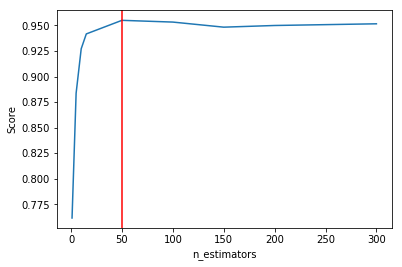

In [19]:
opt = np.argmax(scores_est)

plt.plot(n_estimators, scores_est)
plt.axvline(n_estimators[opt], color='r')
plt.xlabel('n_estimators')
plt.ylabel('Score')

print('Optimal quantity of estimators:', n_estimators[opt])

### 2.5 Количество признаков  (2 балла)

Переберите теперь максимальное количество признаков для `RandomForestClassifier` на 100 деревьях, от 1 до 64 с шагом 5. Постройте график качества по кроссвалидации на 10 фолдах.

In [20]:
n_features_max = np.append([1], range(4, 64, 4))
scores_feat = []

for n in n_features_max:
    clf = RandomForestClassifier(n_estimators=100, max_features=n, n_jobs=4, random_state=42)
    print('n_features_max:', n)
    %time clf.fit(dig_X, dig_y)
    
    scores_feat.append(cross_val_score(clf, dig_X, dig_y, scoring='accuracy', cv=10, n_jobs=4).mean())

n_features_max: 1
CPU times: user 720 ms, sys: 56 ms, total: 776 ms
Wall time: 620 ms
n_features_max: 4
CPU times: user 820 ms, sys: 40 ms, total: 860 ms
Wall time: 592 ms
n_features_max: 8
CPU times: user 1.05 s, sys: 28 ms, total: 1.08 s
Wall time: 861 ms
n_features_max: 12
CPU times: user 1.36 s, sys: 60 ms, total: 1.42 s
Wall time: 1.08 s
n_features_max: 16
CPU times: user 1.53 s, sys: 20 ms, total: 1.55 s
Wall time: 1.21 s
n_features_max: 20
CPU times: user 1.73 s, sys: 16 ms, total: 1.75 s
Wall time: 1.15 s
n_features_max: 24
CPU times: user 1.68 s, sys: 76 ms, total: 1.76 s
Wall time: 1.1 s
n_features_max: 28
CPU times: user 2.05 s, sys: 24 ms, total: 2.07 s
Wall time: 1.42 s
n_features_max: 32
CPU times: user 2 s, sys: 8 ms, total: 2.01 s
Wall time: 1.21 s
n_features_max: 36
CPU times: user 2.06 s, sys: 52 ms, total: 2.11 s
Wall time: 899 ms
n_features_max: 40
CPU times: user 2.26 s, sys: 16 ms, total: 2.27 s
Wall time: 1.08 s
n_features_max: 44
CPU times: user 2.38 s, sys: 28 

Optimal max_features value: 4


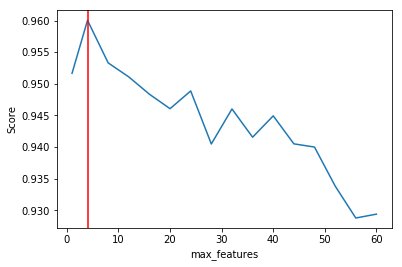

In [21]:
opt = np.argmax(scores_feat)

plt.plot(n_features_max, scores_feat)
plt.axvline(n_features_max[opt], color='r')
plt.xlabel('max_features')
plt.ylabel('Score')

print('Optimal max_features value:', n_features_max[opt])

### 2.5 Вопросы по RandomForest (8 баллов)

Ответьте на вопросы:

- Что происходит с ростом числа деревьев у случайного леса. Можно ли просто всегда брать 5000 деревьев и быть счастливым?
- Как зависит качество предсказания в дереве в зависимости от max_features?
- Почему качество зависит от max_features?
- Как глубина деревьев влияет на качество случайного леса?

1. 

2. 

3. 

4. 

![](https://habrastorage.org/web/ad8/366/a44/ad8366a4469346c6b2e1306495b05d1a.jpg)